### **Notebook for analysing nf pipeline output**

#### All Illumina (seq1-14) - reanalysed

## Packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob, os, re
import matplotlib.pyplot as plt
from datetime import  datetime
from ipywidgets import widgets, interactive

In [2]:
# plt.style.available
plt.style.use('seaborn')
# plt.style.use('seaborn-notebook')
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-colorblind')
# plt.style.use('ggplot')
# plt.style.use('tableau-colorblind10')

In [3]:
dt = datetime.today().strftime(format='%d-%m-%Y')

### **Establish parent directory**

In [4]:
#uniqueness in directory and file names is assumed for all analyses
sars_dir = 'SARS-CoV-2'
run_dir = '20210917_all-Illumina'
home_dir = os.getenv('HOME')
parent_dir = glob.glob(f'{home_dir}/**/{sars_dir}', recursive=True)[0]

## Functions

In [5]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [6]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [7]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [8]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [9]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [10]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [11]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [12]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('.')[0]))
    return df_fnl

### Variants data

In [14]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(glob.glob(f'{parent_dir}/**/{run_dir}/var/k-per-gene_variant_anns.tsv', recursive=True)[0])
df_var_fnl = df_var#df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))

In [15]:
glob.glob(f'{parent_dir}/**/var/k-per-gene_variant_anns.tsv', recursive=True)[0]

'/home/douso/SARS-CoV-2/IlluminaVCOut/20210917_all-Illumina/var/k-per-gene_variant_anns.tsv'

In [16]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COCV11310,17,"E102Q, T265I, F924F, L1507F, G2987V, V3197V, Y...",NaN,D614G,"I20I, Q57H, T175I",NaN,NaN,"L164L, S213fs",NaN,NaN,NaN,NaN,"P13S, R195K, P207T",NaN,NaN,NaN
1,COVC03617,17,"T265I, N430S, F924F, P1330P, A2355S, A2584V, P...",NaN,D614G,"Q57H, H93Y, S253S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN
2,COVC03665,17,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,"A263S, D614G","Q57H, H93Y, S253S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN
3,COVC03696,13,"T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...",NaN,D614G,"S26P, Q57H",NaN,NaN,NaN,W27L,NaN,NaN,F3S,R195K,NaN,NaN,NaN
4,COVC03723,9,"T265I, F924F, L4715L",NaN,D614G,"S26P, Q57H",NaN,NaN,G147G,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN


### Nextclade data

In [17]:
# import Nextclade clade data
df_nxt = pd.read_table(glob.glob(f'{parent_dir}/**/{run_dir}/nxt/nxt.tsv', recursive=True)[0])

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
# df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: '_'.join((x.split('.')[0]).split('_')[1:-1]) if (len(x.split('_')) > 2) else (x.split('_')[0])))
df_nxt_fnl = df_nxt_cln.assign(coverage = coverage).drop('totalMissing', axis=1)

In [18]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,COCV11310,20C,59.8
1,COVC03665,20C,97.5
2,COVC03813,20C,97.9
3,COVC03617,20C,98.6
4,COVC03723,20C,98.9


### Pangolin data v.3.1.11 (08-09-2021) Ran: 18-09-2021

In [19]:
# import Pangolin lineage data
df_png = pd.read_csv(glob.glob(f'{parent_dir}/**/{run_dir}/png/png.csv', recursive=True)[0])
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln#df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [20]:
df_png_fnl.head()

,Sequence_name,Lineage,Scorpio_call
0,COVC03617,B.1,NaN
1,COVC03665,B.1.119,NaN
2,COVC03696,B.1,NaN
3,COVC03723,B.1,NaN
4,COVC03813,B.1,NaN


# Metadata

In [21]:
# import raw metadata file
df_rmd_cln = pd.read_excel(glob.glob(f'{parent_dir}/Outputs/**/COVID19-results-merged-cln.xlsx', recursive=True)[0])

In [22]:
df_rmd_cln.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02


### Ct data

In [23]:
# import Ct data from sheet2 of the metadata file
df_cts = pd.read_excel(glob.glob(f'{parent_dir}/Outputs/**/runsheet-cts.xlsx', recursive=True)[0])

In [24]:
df_cts.head()

,Sample_Name,Well_Position,Dt_Run,Ct_Mean
0,COVC00137,D9,2020-06-03 17:04:05,37.6
1,COVC00154,F2,2020-06-03 17:04:05,35.2
2,COVC00744,D1,2020-06-12 18:14:45,34.7
3,COVC00762,E7,2020-06-12 18:14:45,36.0
4,COVC00767,E12,2020-06-12 18:14:45,34.1


### **Combining data**

#### Merge Variants and Nextclade data

In [25]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [26]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COCV11310,17.0,"E102Q, T265I, F924F, L1507F, G2987V, V3197V, Y...",NaN,D614G,"I20I, Q57H, T175I",NaN,NaN,"L164L, S213fs",NaN,NaN,NaN,NaN,"P13S, R195K, P207T",NaN,NaN,NaN,20C,59.8
1,COVC03617,17.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, P...",NaN,D614G,"Q57H, H93Y, S253S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,98.6
2,COVC03665,17.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,"A263S, D614G","Q57H, H93Y, S253S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,97.5
3,COVC03696,13.0,"T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...",NaN,D614G,"S26P, Q57H",NaN,NaN,NaN,W27L,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,98.7
4,COVC03723,9.0,"T265I, F924F, L4715L",NaN,D614G,"S26P, Q57H",NaN,NaN,G147G,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,98.9


#### Merge pango and var-nextclade data

In [27]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [28]:
df_pngVxt.head()

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COCV11310,NaN,NaN,17.0,"E102Q, T265I, F924F, L1507F, G2987V, V3197V, Y...",NaN,D614G,"I20I, Q57H, T175I",NaN,NaN,...,NaN,NaN,NaN,NaN,"P13S, R195K, P207T",NaN,NaN,NaN,20C,59.8
1,COVC03617,B.1,NaN,17.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, P...",NaN,D614G,"Q57H, H93Y, S253S",NaN,NaN,...,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,98.6
2,COVC03665,B.1.119,NaN,17.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,"A263S, D614G","Q57H, H93Y, S253S",NaN,NaN,...,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,97.5
3,COVC03696,B.1,NaN,13.0,"T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...",NaN,D614G,"S26P, Q57H",NaN,NaN,...,W27L,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,98.7
4,COVC03723,B.1,NaN,9.0,"T265I, F924F, L4715L",NaN,D614G,"S26P, Q57H",NaN,NaN,...,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,98.9


In [29]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Scorpio call',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [30]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Ct_Mean': 'AVG_Ct'})

In [31]:
df_rmdCts.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,Well_Position,Dt_Run,AVG_Ct
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,Unknown,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [32]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [33]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'SCORP_CALL', 'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a',
       'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a',
       'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE_YRS', 'GEND', 'OCCU', 'NAT',
       'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE',
       'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 'DT_CONF',
       'Well_Position', 'Dt_Run', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [34]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'COCV11310', 'COVC28286'}


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [35]:
header_MS = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [36]:
header_policy = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [37]:
df_ill_nodup = pd.read_excel(glob.glob(f'{parent_dir}/**/no_duplicate_ill_17-09-2021.xlsx', recursive=True)[0])
df_ill_nodup_ids = df_ill_nodup['sample_id'].tolist()

In [38]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
df_vnpPmd_fnl = df_vnpPmd_fnl[df_vnpPmd_fnl['S_NUM'].isin(df_ill_nodup_ids) == True]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-M-ILL_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [39]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
df_vnpPmd_fnl = df_vnpPmd_fnl[df_vnpPmd_fnl['S_NUM'].isin(df_ill_nodup_ids) == True]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/metadata-seq-MS-ILL_{dt}.xlsx"
                     , index=False, na_rep='NA', float_format='%.1f'))
# df_vnpPmd_fnl.head()

### **Feedback Data**

### CDC VoI

In [40]:
gamma = ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I']
delta = ['T19R', '(V70F*)', 'T95I', 'G142D', 'E156-', 'F157-', 'R158G', '(A222V*)', '(W258L*)', '(K417N*)', 
         'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
beta = ['D80A', 'D215G', '241del', '242del', '243del', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
alpha = ['69del', '70del', '144del', '(E484K*)', '(S494P*)', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H', '(K1191N*)']

### CDC VoC

In [41]:
B16173 = ['T19R', 'G142D', 'L452R', 'E484Q', 'D614G', 'P681R', 'D950N']
kappa = ['(T95I)', 'G142D', 'E154K', 'L452R', 'E484Q', 'D614G', 'P681R', 'Q1071H']
iota = ['L5F', '(D80G*)', 'T95I', '(Y144-*)', '(F157S*)', 'D253G', '(L452R*)', '(S477N*)', 
        'E484K', 'D614G', 'A701V', '(T859N*)', '(D950H*)', '(Q957R*)']
eta = ['A67V', '69del', '70del', '144del', 'E484K', 'D614G', 'Q677H', 'F888L']

In [42]:
x = (set(gamma).union(set(delta)).union(set(beta)).union(set(alpha))).union(set(B16173).union(set(kappa)).union(set(iota)).union(set(eta)))
# x

### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant (Alpha)
 - N501Y, E484K, *K417N (B.1.351): SA variant (Beta)
 - N501Y, E484K (P.1): Brazilian variant (Gamma)
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant (Delta)
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple (Eta)
 - L5F, T95I, D253G, A701V (B.1.526): USA (Iota)
 - G142D, E154K, Q1071H ('B.1.617.1'): Indian (Kappa)

In [43]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A', 'Q677H', 'F888L', 'L5F', 'D253G', 'E154K', 'A67V']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [44]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,COVC18558,E484Q,"E484Q, D614G"
1,COVC18975,N501Y,N501Y
2,COVC20146,"P681R, L452R","Y145del, R246K, G261D, L452R, P681R, P681H, T7..."
3,COVC20421,P681R,"Y145del, P681R, P681H, T716I, D1118H"
4,COVC20783,P681R,"Y145del, P681R, P681H, T716I"


### Subsample brief data

In [45]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [46]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 70]

In [47]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,SCORP_CALL,COUNT_RES,GEND,NAT
1,COVC03617,98.6,2020-07-06,NaT,B.1,20C,NaN,Nairobi,F,Kenya
2,COVC03665,97.5,2020-07-06,NaT,B.1.119,20C,NaN,Nairobi,M,Kenya
3,COVC03696,98.7,2020-07-06,NaT,B.1,20C,NaN,Nairobi,M,Kenya
4,COVC03723,98.9,2020-07-06,NaT,B.1,20C,NaN,Nairobi,M,Kenya
5,COVC03813,97.9,2020-07-10,NaT,B.1,20C,NaN,Nairobi,M,Kenya


#### Merge df_brief with df_moc

In [48]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [49]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [50]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC03617,98.6,2020-07-06 00:00:00,N/A,B.1,20C,N/A,Nairobi,F,Kenya,N/A
1,COVC03665,97.5,2020-07-06 00:00:00,N/A,B.1.119,20C,N/A,Nairobi,M,Kenya,N/A
2,COVC03696,98.7,2020-07-06 00:00:00,N/A,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC03723,98.9,2020-07-06 00:00:00,N/A,B.1,20C,N/A,Nairobi,M,Kenya,N/A
4,COVC03813,97.9,2020-07-10 00:00:00,N/A,B.1,20C,N/A,Nairobi,M,Kenya,N/A


In [51]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [52]:
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [53]:
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [54]:
# df_report_fnl = df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].str.contains('KEMRI') == False]

In [55]:
df_report_fnl = df_brfMoc_fnl

In [56]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC03617,98.6,2020-07-06,NaT,B.1,20C,N/A,Nairobi,F,Kenya,N/A
1,COVC03665,97.5,2020-07-06,NaT,B.1.119,20C,N/A,Nairobi,M,Kenya,N/A
2,COVC03696,98.7,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC03723,98.9,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
4,COVC03813,97.9,2020-07-10,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A


In [57]:
df_report_fnl.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-T-ILL_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f')

In [58]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [59]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC03617,98.6,2020-07-06,NaT,B.1,20C,N/A,Nairobi,F,Kenya,N/A
1,COVC03665,97.5,2020-07-06,NaT,B.1.119,20C,N/A,Nairobi,M,Kenya,N/A
2,COVC03696,98.7,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC03723,98.9,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
4,COVC03813,97.9,2020-07-10,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
...,...,...,...,...,...,...,...,...,...,...,...
717,NPHL-12762,98.0,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Unknown,N/A,Kenya,"A570D, N501Y"
718,NPHL-12773,99.6,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Unknown,N/A,Kenya,"A570D, N501Y"
719,NPHL1,98.7,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Unknown,N/A,Kenya,"A570D, N501Y"
720,NPHL2,74.1,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",N/A,Unknown,N/A,Kenya,A570D


In [60]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Kiambu         311
Nairobi        156
Mombasa         73
Siaya           33
Homabay         30
Meru            27
Unknown         21
Kajiado         13
Garissa         12
Murang'a         9
Kirinyaga        8
Laikipia         7
Nakuru           7
Uasin gishu      5
Makueni          5
Machakos         2
Nyeri            1
Nyandarua        1
Embu             1
Name: Sample County of Origin, dtype: int64

In [61]:
clr_code = {'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),#'TBA32': ('darkkhaki', '#BDB76B'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('chocolate', '#D2691E'),
 'TBA43': ('steelblue', '#4682B4'),
 'TBA44': ('magenta', '#FF00FF'),
 'TBA45': ('rosybrown', '#BC8F8F'),
 'TBA46': ('goldenrod', '#DAA520'),
 'TBA47': ('paleturquoise', '#FF0000'),
 'TBA10': ('lavender', '#E6E6FA'),
 'TBA12': ('pink', '#FFC0CB'),
 'TBA14': ('seashell', '#FFFAF0'),
 'TBA16': ('mediumvioletred', '#C71585'),
 'TBA18': ('black', '#000000'),#'TBA2': ('cornflowerblue', '#FFF5EE'),
 'TBA20': ('saddlebrown', '#8B4513'),
 'TBA21': ('wheat', '#F5DEB3'),
 'TBA22': ('slategray', '#708090'),
 'TBA23': ('silver', '#C0C0C0'),
 'TBA04': ('midnightblue', '#191970'),
 'TBA06': ('darkgreen', '#7FFFD4'),
 'TBA08': ('darkseagreen', '#F0FFF0')}#BLUES NEXT B.1.361
avail_clr = list(clr_code.keys())

In [62]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [63]:
max_count = grpby_lins['Sequence Name'].max()

In [64]:
clr_code_keys = list(clr_code.keys())

In [65]:
lins = list(grpby_lins.index)

In [66]:
lin_tba =  set(lins) - set(clr_code_keys)
lin_tba

{'A',
 'A.2.3',
 'A.23',
 'A.23.1',
 'A.25',
 'AY.12',
 'AY.4',
 'B.1',
 'B.1.1',
 'B.1.1.1',
 'B.1.1.318',
 'B.1.1.519',
 'B.1.1.7',
 'B.1.119',
 'B.1.143',
 'B.1.153',
 'B.1.160',
 'B.1.214',
 'B.1.276',
 'B.1.336',
 'B.1.343',
 'B.1.351',
 'B.1.390',
 'B.1.391',
 'B.1.393',
 'B.1.405',
 'B.1.433',
 'B.1.446',
 'B.1.509',
 'B.1.524',
 'B.1.525',
 'B.1.527',
 'B.1.530',
 'B.1.540',
 'B.1.549',
 'B.1.577',
 'B.1.596.1',
 'B.1.605',
 'B.1.612',
 'B.1.617.2',
 'N/A'}

In [67]:
print(f'length of lins to be assigned: {len(lin_tba)}')
print(f'length of colours available: {len(avail_clr)}')

length of lins to be assigned: 41
length of colours available: 47


In [68]:
lin_clrs = {}
for z in zip(lins, avail_clr):
#     print(z)
    lin_clrs[z[0]] = clr_code[z[1]][1]
#     clr_code.pop(z[1])
#     avail_clr.remove(z[1])
# lin_clrs

In [69]:
import pprint
# pprint.pprint(clr_code)
# pprint.pprint(avail_clr)
pprint.pprint(lin_clrs)

{'A': '#9370DB',
 'A.2.3': '#DAA520',
 'A.23': '#FFFF00',
 'A.23.1': '#708090',
 'A.25': '#000000',
 'AY.12': '#2E8B57',
 'AY.4': '#008080',
 'B.1': '#00FF00',
 'B.1.1': '#808000',
 'B.1.1.1': '#C71585',
 'B.1.1.318': '#1E90FF',
 'B.1.1.519': '#D2B48C',
 'B.1.1.7': '#808080',
 'B.1.119': '#FFFAF0',
 'B.1.143': '#FFC0CB',
 'B.1.153': '#0000FF',
 'B.1.160': '#E6E6FA',
 'B.1.214': '#FF0000',
 'B.1.276': '#4B0082',
 'B.1.336': '#9ACD32',
 'B.1.343': '#800080',
 'B.1.351': '#FFD700',
 'B.1.390': '#BC8F8F',
 'B.1.391': '#FF00FF',
 'B.1.393': '#483D8B',
 'B.1.405': '#4682B4',
 'B.1.433': '#D2691E',
 'B.1.446': '#A52A2A',
 'B.1.509': '#008000',
 'B.1.524': '#F0E68C',
 'B.1.525': '#8FBC8F',
 'B.1.527': '#A0522D',
 'B.1.530': '#D2691E',
 'B.1.540': '#006400',
 'B.1.549': '#00FFFF',
 'B.1.577': '#6495ED',
 'B.1.596.1': '#FFA500',
 'B.1.605': '#AFEEEE',
 'B.1.612': '#DB7093',
 'B.1.617.2': '#FF4500',
 'N/A': '#8B4513'}


In [70]:
#updated colour code
clr_code

{'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('ch

In [71]:
def replace_with_who_lin(x):
    if x == 'B.1.1.7':
        return x.replace(x, 'B.1.1.7(Alpha)')
    elif x == 'B.1.617.2':
        return x.replace(x, 'B.1.617.2(Delta)')
    elif x == 'B.1.351':
        return x.replace(x, 'B.1.351(Beta)')
    elif x == 'B.1.525':
        return x.replace(x, 'B.1.525(Eta)')
    elif x == 'AY.4':
        return x.replace(x, 'AY.4(Delta)')
    elif x == 'AY.12':
        return x.replace(x, 'AY.12(Delta)')
    return x
    

In [72]:
xlabels = list(map(replace_with_who_lin,list(grpby_lins.sort_index().index)))

In [73]:
lins = (df_report_fnl.groupby('Pango Lineage Annotation').count()
 .coverage.sort_index())

In [74]:
lins.index=xlabels

In [75]:
lins.sort_values(ascending=False)

B.1                 218
B.1.1.7(Alpha)      216
B.1.617.2(Delta)     65
B.1.549              41
B.1.530              33
AY.4(Delta)          27
A.23.1               22
B.1.596.1            11
AY.12(Delta)         10
B.1.1                10
B.1.351(Beta)         8
B.1.525(Eta)          8
B.1.540               7
B.1.336               4
B.1.1.519             4
B.1.276               3
A                     3
B.1.153               3
B.1.393               2
B.1.527               2
B.1.524               2
B.1.1.318             2
B.1.612               2
A.23                  2
B.1.577               1
B.1.509               1
B.1.605               1
B.1.343               1
B.1.446               1
B.1.433               1
B.1.405               1
B.1.391               1
B.1.390               1
A.2.3                 1
B.1.214               1
B.1.160               1
B.1.143               1
B.1.119               1
B.1.1.1               1
A.25                  1
N/A                   1
Name: coverage, 

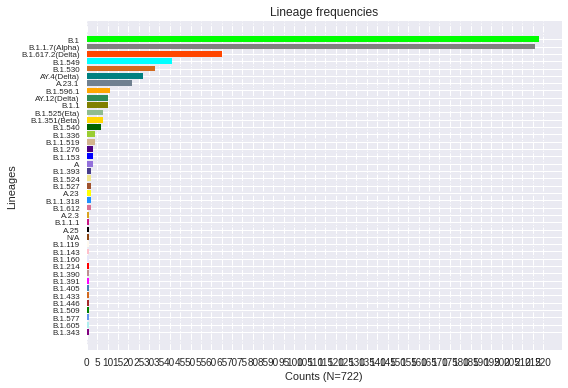

In [76]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=True)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
# colors = [clr[1] for clr in clr_code.values()]
n = lins.sum()
xticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts()
#  .sort_values(ascending=False)
plt.barh(width.index, width, color=colors)
plt.title('Lineage frequencies')
plt.ylabel('Lineages')
plt.xticks(xticks, xticks)
plt.yticks(width.index, fontsize=8)
plt.xlabel(f'Counts (N={n})')
plt.grid('major', axis='x', ls='-.')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P-ILLh.png')
plt.show()

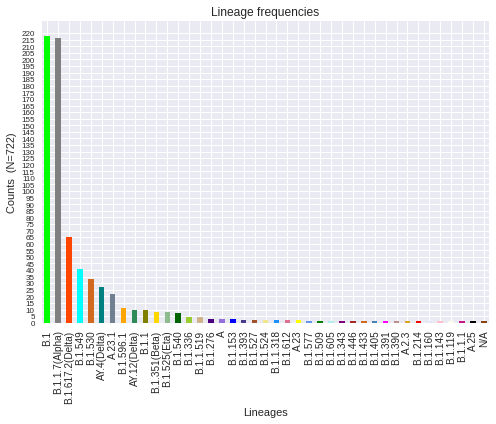

In [77]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=False)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots(figsize=(7,6))
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts().
width.plot(kind='bar', ax=ax, color=colors)
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks, fontsize=8)
plt.xticks(ticks=range(len(lins)), rotation=90, labels=width.index)
plt.ylabel(f'Counts  (N={n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P-ILL.png')
plt.show()

In [78]:
df_report_fnl

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC03617,98.6,2020-07-06,NaT,B.1,20C,N/A,Nairobi,F,Kenya,N/A
1,COVC03665,97.5,2020-07-06,NaT,B.1.119,20C,N/A,Nairobi,M,Kenya,N/A
2,COVC03696,98.7,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC03723,98.9,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
4,COVC03813,97.9,2020-07-10,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
...,...,...,...,...,...,...,...,...,...,...,...
717,NPHL-12762,98.0,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Unknown,N/A,Kenya,"A570D, N501Y"
718,NPHL-12773,99.6,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Unknown,N/A,Kenya,"A570D, N501Y"
719,NPHL1,98.7,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Unknown,N/A,Kenya,"A570D, N501Y"
720,NPHL2,74.1,NaT,2021-04-07,B.1.1.7,"20I (Alpha, V1)",N/A,Unknown,N/A,Kenya,A570D


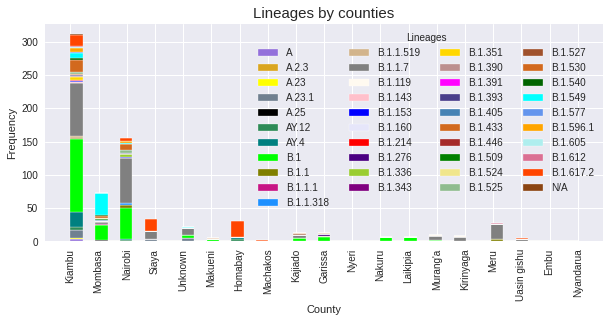

<Figure size 576x396 with 0 Axes>

In [79]:
# Prepare data
df = df_report_fnl[df_report_fnl['Pango Lineage Annotation'].isin(['Failed', 'Unkown']) == False]

x_var = 'Sample County of Origin'
groupby_var = 'Pango Lineage Annotation'
df_agg = df[[x_var, groupby_var]].groupby(groupby_var)
vals = [d[x_var].values.tolist() for i, d in df_agg]

colors = {i: lin_clrs[i] for i, df in df_agg}
# Draw
plt.figure(figsize=(10,4))
# colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, len(df_agg[x_var].unique()),
                            stacked=True, density=False,
                            color=colors.values(), ec='w', rwidth=1)

# Decoration
plt.legend(colors, title='Lineages', ncol=4)
plt.title(f"Lineages by counties", fontsize=15)
plt.xlabel('County')
plt.ylabel("Frequency")
# plt.ylim(0, 40)
plt.xticks(rotation=90)
plt.show()
plt.tight_layout()

In [80]:
df.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC03617,98.6,2020-07-06,NaT,B.1,20C,N/A,Nairobi,F,Kenya,N/A
1,COVC03665,97.5,2020-07-06,NaT,B.1.119,20C,N/A,Nairobi,M,Kenya,N/A
2,COVC03696,98.7,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC03723,98.9,2020-07-06,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A
4,COVC03813,97.9,2020-07-10,NaT,B.1,20C,N/A,Nairobi,M,Kenya,N/A


<Figure size 720x288 with 0 Axes>

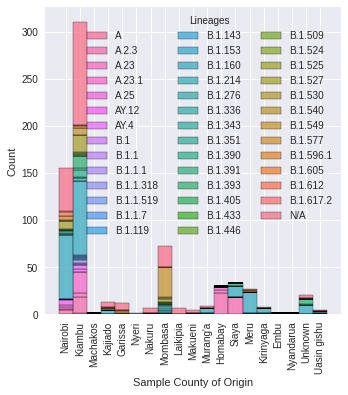

In [81]:
plt.figure(figsize=(10,4))
sns.displot(df, x='Sample County of Origin', 
            hue='Pango Lineage Annotation',multiple="stack",
           legend=False)
plt.xticks(rotation=90)
plt.legend(colors, title='Lineages', ncol=3)

/home/douso/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/douso/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/douso/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/douso/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/douso/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Da

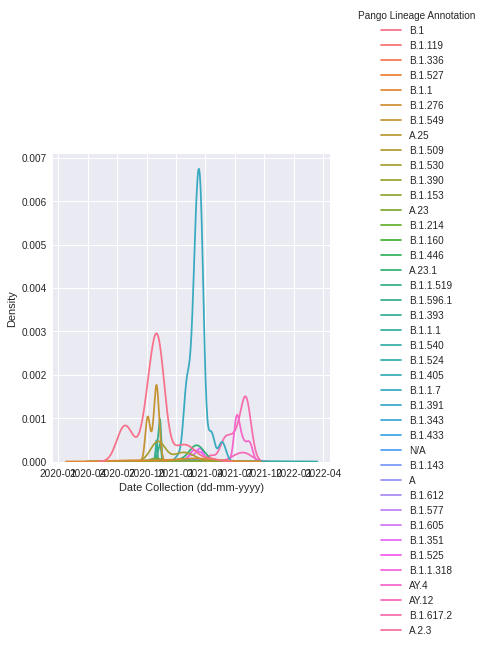

In [82]:
sns.displot(df, x='Date Collection (dd-mm-yyyy)', hue='Pango Lineage Annotation',kind="kde")

In [83]:
Siaya       32
Homabay     25
Kiambu      14
Nairobi      9
Mombasa      1
Machakos     1
Makueni      1

SyntaxError: invalid syntax (<ipython-input-83-5dd797f10c24>, line 1)

In [ ]:
df_agg.groups